In [1]:
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display
from tqdm import tqdm
#to play audio
import IPython.display as ipd
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Flatten, Bidirectional
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC
import os
import shutil
label_csv = '../input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv'
audio_fpath = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/"

In [2]:
class AudioAugmentation:   
    def add_noise(self, data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.005 * noise
        return data_noise
    
    def shift(self, data):
        return np.roll(data, 6614)
    
    def stretch(self, data, rate=1):
        input_length = 16000
        data = librosa.effects.time_stretch(data, rate)
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data
        

In [3]:

audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))
df = pd.read_csv(label_csv)

print(df.head())
df.shape

No. of .wav files in audio folder =  10
            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  .

(9990, 60)

In [4]:
x, sr = librosa.load('../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav')

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [5]:
audio_duration = x.shape[0] / sr

In [6]:
extracted_data = []
for index, row in tqdm(df.iterrows()):
    mfcc = []
    class_labels = row['label']
    for i in range(1,21):
        mfcc.append(row['mfcc'+ str(i)+'_mean'])
    extracted_data.append([mfcc, class_labels])
print(extracted_data[0][0])

9990it [00:01, 5335.48it/s]

[-118.62791442871094, 125.08362579345705, -23.443723678588867, 41.32148361206055, -5.976108074188232, 20.115140914916992, -16.04541015625, 17.85519790649414, -14.633434295654297, 10.270526885986328, -9.70827865600586, 10.18387508392334, -4.681614398956299, 8.417439460754395, -7.233476638793945, -2.8536033630371094, -3.2412803173065186, 0.7222089767456055, -5.05033540725708, -0.2430267930030822]


In [7]:
np.array(extracted_data).shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(9990, 2)

In [8]:
feature_df = pd.DataFrame(extracted_data, columns=['feature','class'])

feature_df.head()

,feature,class
0,"[-118.62791442871094, 125.08362579345705, -23....",blues
1,"[-125.59070587158205, 122.42122650146484, -20....",blues
2,"[-132.4419403076172, 115.08517456054688, -14.8...",blues
3,"[-118.23108673095705, 132.1165008544922, -18.7...",blues
4,"[-105.96837615966795, 134.64364624023438, -19....",blues


In [9]:
x = np.array(feature_df['feature'].tolist())

x.shape

(9990, 20)

In [10]:
target = np.array(feature_df['class'].tolist())

In [11]:
y_new = pd.get_dummies(target)
print(y_new.shape)
y_new.head()

(9990, 10)


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y_new, 
                                                    test_size=0.2, 
                                                    random_state=15)

print(str(X_train.shape)+ ', ' + str(X_test.shape))
inp = (1, 20)
np.array(X_train).reshape(7992, 1, 20)

(7992, 20), (1998, 20)


array([[[-3.24867615e+02,  1.77975204e+02,  2.40419998e+01, ...,
         -4.34563017e+00, -1.80160451e+00, -3.90213466e+00]],

       [[-2.58889618e+02,  1.16611534e+02,  1.84107578e+00, ...,
          5.05907498e-02,  4.80156851e+00,  7.27069259e-01]],

       [[-5.71014290e+01,  7.48747330e+01, -4.52312965e+01, ...,
          9.32623744e-01,  1.13561332e+00,  2.13897491e+00]],

       ...,

       [[-1.89605316e+02,  1.17735802e+02, -1.24772348e+01, ...,
          4.06341553e+00, -2.26114249e+00, -2.24034995e-01]],

       [[-1.76899078e+02,  1.19373657e+02, -2.55092049e+00, ...,
         -8.90102625e-01, -6.22514772e+00, -3.14809155e+00]],

       [[-1.38830536e+02,  1.23055527e+02, -6.22227848e-01, ...,
         -1.04806509e+01, -1.19253898e+00,  2.82588601e+00]]])

In [13]:
np.array(X_train).reshape(7992,1,20)

array([[[-3.24867615e+02,  1.77975204e+02,  2.40419998e+01, ...,
         -4.34563017e+00, -1.80160451e+00, -3.90213466e+00]],

       [[-2.58889618e+02,  1.16611534e+02,  1.84107578e+00, ...,
          5.05907498e-02,  4.80156851e+00,  7.27069259e-01]],

       [[-5.71014290e+01,  7.48747330e+01, -4.52312965e+01, ...,
          9.32623744e-01,  1.13561332e+00,  2.13897491e+00]],

       ...,

       [[-1.89605316e+02,  1.17735802e+02, -1.24772348e+01, ...,
          4.06341553e+00, -2.26114249e+00, -2.24034995e-01]],

       [[-1.76899078e+02,  1.19373657e+02, -2.55092049e+00, ...,
         -8.90102625e-01, -6.22514772e+00, -3.14809155e+00]],

       [[-1.38830536e+02,  1.23055527e+02, -6.22227848e-01, ...,
         -1.04806509e+01, -1.19253898e+00,  2.82588601e+00]]])

In [14]:
model = Sequential()
model.add(Input(shape = (1,20)))
model.add(Bidirectional(LSTM(512, return_sequences = True, recurrent_dropout = 0.2, dropout = 0.2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', AUC()]
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 1024)           2183168   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 2,193,418
Trainable params: 2,193,418
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
es = EarlyStopping(
    monitor='val_accuracy', restore_best_weights=True, patience=20, min_delta = 0.001
)

history = model.fit(
    np.array(X_train).reshape(7992, 1, 20),
    np.array(y_train),
    epochs=500,
    callbacks = [es],
    shuffle = True,
    batch_size = 512,
    validation_data = (
        np.array(X_test).reshape(1998,1,20),
        np.array(y_test)
    )
)
model.save('LSTM')

Epoch 1/500
16/16 [==============================] - 6s 54ms/step - loss: 1.9132 - accuracy: 0.3188 - auc: 0.7605 - val_loss: 1.5337 - val_accuracy: 0.4580 - val_auc: 0.8610
Epoch 2/500
16/16 [==============================] - 0s 14ms/step - loss: 1.5704 - accuracy: 0.4481 - auc: 0.8548 - val_loss: 1.3719 - val_accuracy: 0.4975 - val_auc: 0.8921
Epoch 3/500
16/16 [==============================] - 0s 14ms/step - loss: 1.4389 - accuracy: 0.4884 - auc: 0.8819 - val_loss: 1.2807 - val_accuracy: 0.5420 - val_auc: 0.9062
Epoch 4/500
16/16 [==============================] - 0s 14ms/step - loss: 1.3535 - accuracy: 0.5226 - auc: 0.8962 - val_loss: 1.1993 - val_accuracy: 0.5781 - val_auc: 0.9183
Epoch 5/500
16/16 [==============================] - 0s 14ms/step - loss: 1.3020 - accuracy: 0.5353 - auc: 0.9046 - val_loss: 1.1685 - val_accuracy: 0.5876 - val_auc: 0.9221
Epoch 6/500
16/16 [==============================] - 0s 14ms/step - loss: 1.2638 - accuracy: 0.5562 - auc: 0.9105 - val_loss: 1.12

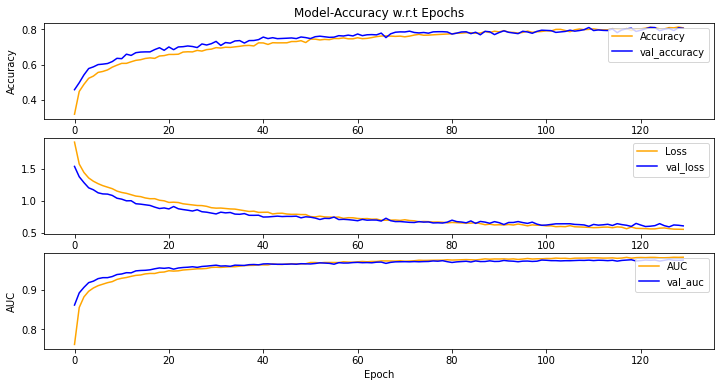

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,6))
ax2.plot(history.history['loss'], color='orange', label='Loss')
ax2.plot(history.history['val_loss'], color='blue', label='val_loss')
ax2.legend(loc='upper right')
ax1.plot(history.history['accuracy'], label='Accuracy', color='orange')
ax1.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
ax1.legend(loc="upper right")
ax1.set_title("Model-Accuracy w.r.t Epochs", loc='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax3.plot(history.history['auc'], color='orange', label='AUC')
ax3.plot(history.history['val_auc'], color='blue', label='val_auc')
ax3.set_xlabel("Epoch")
ax3.set_ylabel("AUC")
ax3.legend(loc='upper right')
plt.savefig('model_acc_LSTM_GTZAN.png')
# ax3.set_title("AUC of model w.r.t Epochs", loc='center')

In [17]:
y_pred = model.predict(np.array(x).reshape(9990, 1,20))

y_pred_classes = np.argmax(y_pred, axis=1)

y_pred.shape

(9990, 10)

In [18]:
y_true = np.argmax(np.array(y_new), axis=1)

y_true

array([0, 0, 0, ..., 9, 9, 9])

In [19]:
print(np.mean(y_pred_classes == y_true))
m = AUC()
m.update_state(y_new, y_pred)
print(m.result())

0.8800800800800801
tf.Tensor(0.99042857, shape=(), dtype=float32)


<Figure size 432x288 with 0 Axes>

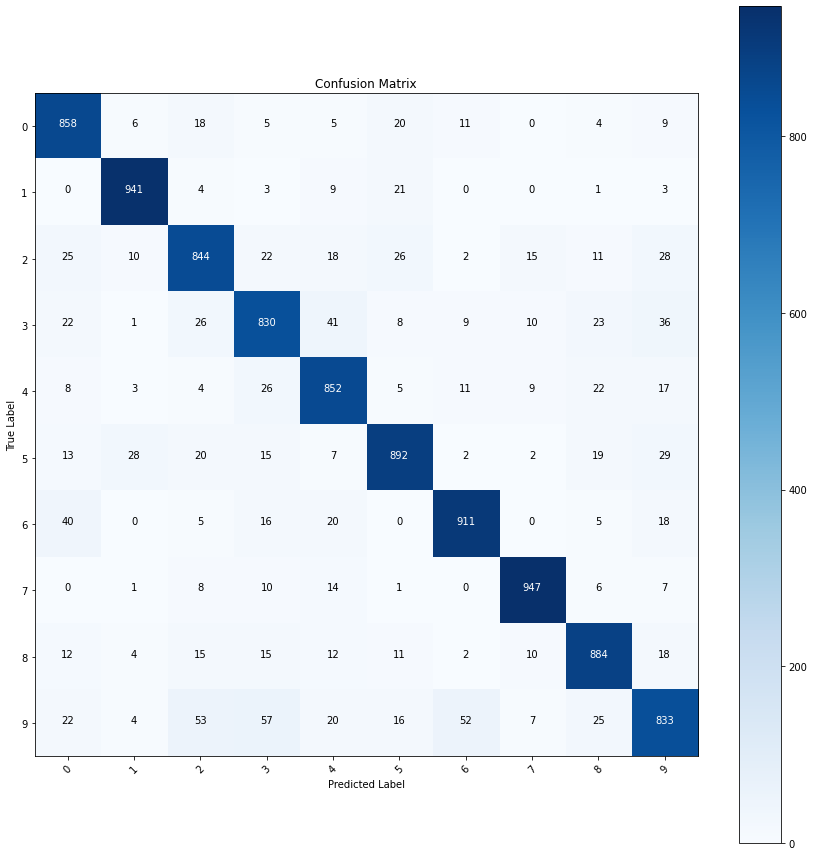

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_classes, y_true,)
import itertools
plt.clf()
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.imshow(cm, cmap = plt.cm.Blues, interpolation='nearest')

plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(range(10)))
plt.xticks(tick_marks, range(10), rotation=45)
plt.yticks(tick_marks, range(10))
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i , cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")

plt.tight_layout()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('con_matrix_LSTM_GTZAN.png')